# Horizontal Lyapunov Orbits
### for L1/L2 using differential corrections

#### tested on Sun-Earth (default), Earth-Moon (default) system

In [1]:
import orbipy as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# available systems (constant sets for systems)
systems = list(op.crtbp3_model.constants_df.index)
systems

['Sun-Earth (default)',
 'Earth-Moon (default)',
 'Sun-Venus (2026-12-05)',
 'Extreme 0.49']

In [3]:
# USER: select system
system = systems[1]
system

'Earth-Moon (default)'

In [4]:
# USER: select Lagrange point (L1 or L2)
point_name = 'L2'
print('Horizontal Lyapunov family calculation near', point_name, 'in', system, 'system')

Horizontal Lyapunov family calculation near L2 in Earth-Moon (default) system


In [5]:
# USER: set minimum distance to small body in km
# Sun-Earth system: 1000, 1e-12
# Earth-Moon system: 2000, 1e-14

min_dist = 2000
tol = 1e-14

In [7]:
# create model, plotter, scaler
model = op.crtbp3_model(system) #model for calculations
model.integrator.set_params(atol=tol, rtol=tol)
plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='m/s')
scale = plotter.scaler

# model with State Transition Matrix for differential corrections
stmmodel = op.crtbp3_model(system, stm=True)
stmmodel.integrator.set_params(atol=tol, rtol=tol)

pmodel = op.crtbp3_model(system) #model for plotting (with small time step)
pmodel.integrator.set_params(max_step=scale(1, 'd-nd'))
pmodel.integrator.set_params(atol=tol, rtol=tol)

In [8]:
Lpoint = model.__getattribute__(point_name)
RL = model.mu1-Lpoint # distance small body-L1/L2
dx0 = RL/1500 # initial step between orbits by x coordinate
x0 = Lpoint+dx0 # initial spacecraft position at X-axis

In [10]:

# initial step size in kilometers
scale(dx0, 'nd-km')

np.float64(-43.01916841960223)

Calculations are made in 2 steps:
1. Calculate 4 initial orbits with initial x coordinates [x0, x0+dx, x0+2\*dx, x0+3\*dx] using border correction method
2. Using cubic interpolation for initial guess of Vy, quadratic interpolation for initial guess of dx, calculate main set of orbits with energy levels j(i)=j(i-1)+dji, where dj(i) = dj(i-1)\*1.001. Differential correction method based on STM are used. X-coordinate interval is: [x0+4\*dx0, mu1-1000 km].

*x0 = L1 + dx, where dx0 = RL1/1000, RL1 = mu1 - L1*

In [11]:
# events for calculation of 4 small orbits using border correction method
left   = op.eventX(Lpoint-10*dx0, accurate=False)
right  = op.eventX(Lpoint+10*dx0, accurate=False)

corr_planes = op.border_correction(model, op.y_direction(), [left], [right])

/home/tka4nik/Workdir/diploma/orbipy/venv/lib64/python3.12/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/orbipy/venv/lib64/python3.12/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
/home/tka4nik/Workdir/diploma/orbipy/venv/lib64/python3.12/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/tka4nik/Workdir/diploma/orbipy/venv/lib64/python3.12/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Serie

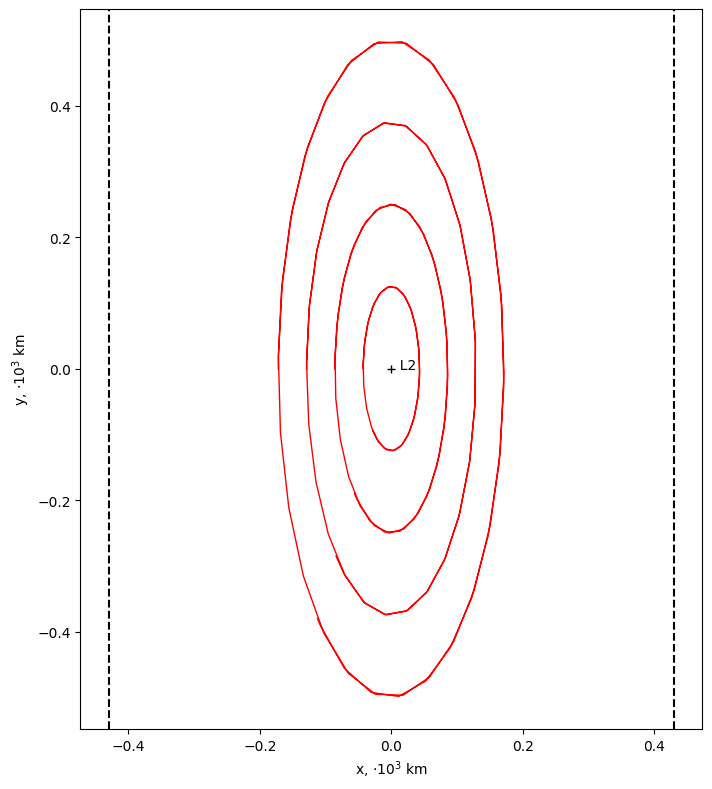

In [12]:
# calculate 4 initial states for small orbits near L1 using border correction method

states = []
# create figure and plot Lagrange point
ax = plotter.plot_proj(plottables=[plotter.__getattribute__(point_name)], fsize=(12,8),
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='', marker='+')

# plot left and right events (planes)
plotter.plot_proj(ax=ax, plottables=[left, right], 
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='--')

# calculate 4 orbits and plot them
for x in [x0, x0+dx0, x0+2*dx0, x0+3*dx0]:
    s0 = model.get_zero_state()
    s0[0] = x
    corr_planes.mode = 0
    dv = corr_planes.calc_dv(0.0, s0)
    s0 += dv
    states.append(s0.copy())
    df = pmodel.prop(s0, 0., 2*np.pi)
    plotter.plot_proj(df, ax=ax, projections=('x-y',),
                      centers={'x':Lpoint}, colors='rgb', linewidth=1)
    #ax.plot((x-model.L1)*model.R/1000, 0, '.k')
ax.set_aspect('equal')

In [13]:
# initialize differential correction algorithm
dc = op.differential_correction(stmmodel, iterations=100, tol=1e-12)

In [14]:
# initial step size for energy (Jacobi constant)
dj = (model.jacobi(states[-1])-model.jacobi(states[-2]))
dj

np.float64(-1.920447510350698e-06)

In [16]:
# start, end x coordinates
x = states[-1][0]
sgn = (1 if dx0 > 0 else -1)
xend = model.mu1 - sgn*min_dist/model.R
print('x_end:', (xend - Lpoint)*model.R)

x_end: -62528.75262940335


In [17]:
i = 0
while sgn*x < sgn*xend:   
    dx_int = interp1d([model.jacobi(states[j]) for j in range(-4, 0)],
                    [states[j][0] for j in range(-4, 0)], 
                    kind='quadratic',
                    fill_value='extrapolate')
    vint = interp1d([states[j][0] for j in range(-4, 0)],
                    [states[j][4] for j in range(-4, 0)], 
                    kind='cubic',
                    fill_value='extrapolate')
    new_x = dx_int(model.jacobi(states[-1])+dj) # calculate next x coordinate using energy step size dj
    dx = new_x - states[-1][0] # calculate dx step size (only for console output)
    sgn_dx = (1 if dx > 0 else -1)
    if sgn_dx != sgn:
        dx = states[-1][0]-states[-2][0]
    x += dx
    s1 = stmmodel.get_zero_state()
    s1[0] = x
    s1[4] = vint(x) # calculate initial vy guess for current orbit
    try:
        s2, it = dc.find_halo(s1, fixed='x0', ret_it=True, ftol=tol*1e2) # apply differential corrections
    except BaseException as e:
        print('Retry orbit:', '%04d'%i, '%10.2f'%((x-Lpoint)*model.R), '%02d'%it, '%.6f'%(dx*model.R))
        dj *= (1 - 0.1)
        continue
    states.append(s2[:6].copy())
    print('%04d'%i, '%10.2f'%((x-Lpoint)*model.R), '%02d'%it, '%.6f'%(dx*model.R))
    i += 1
    if it < 5:
        dj *= (1 + 0.01) # slightly increase energy step if iteration number is small (by 1%)
    elif it > 10:
        dj *= (1 - 0.01) # slightly decrease step otherwise

0000    -202.17 01 -30.096861
0001    -230.65 01 -28.471725
0002    -256.72 01 -26.072787
0003    -280.92 01 -24.205262
0004    -303.64 01 -22.715384
0005    -325.11 01 -21.468754
0006    -345.53 01 -20.421388
0007    -365.06 01 -19.531410
0008    -383.83 01 -18.766762
0009    -401.93 01 -18.103147
0010    -419.45 01 -17.521985
0011    -436.46 01 -17.008943
0012    -453.01 01 -16.552824
0013    -469.16 01 -16.144777
0014    -484.94 01 -15.777722
0015    -500.38 01 -15.445926
0016    -515.53 01 -15.144701
0017    -530.40 01 -14.870177
0018    -545.02 01 -14.619127
0019    -559.41 01 -14.388840
0020    -573.58 01 -14.177020
0021    -587.56 01 -13.981709
0022    -601.37 01 -13.801227
0023    -615.00 01 -13.634124
0024    -628.48 01 -13.479138
0025    -641.81 01 -13.335171
0026    -655.01 01 -13.201257
0027    -668.09 01 -13.076547
0028    -681.05 01 -12.960288
0029    -693.90 03 -12.851813
0030    -706.65 00 -12.750526
0031    -719.31 02 -12.655894
0032    -731.88 03 -12.567439
0033    -7

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 

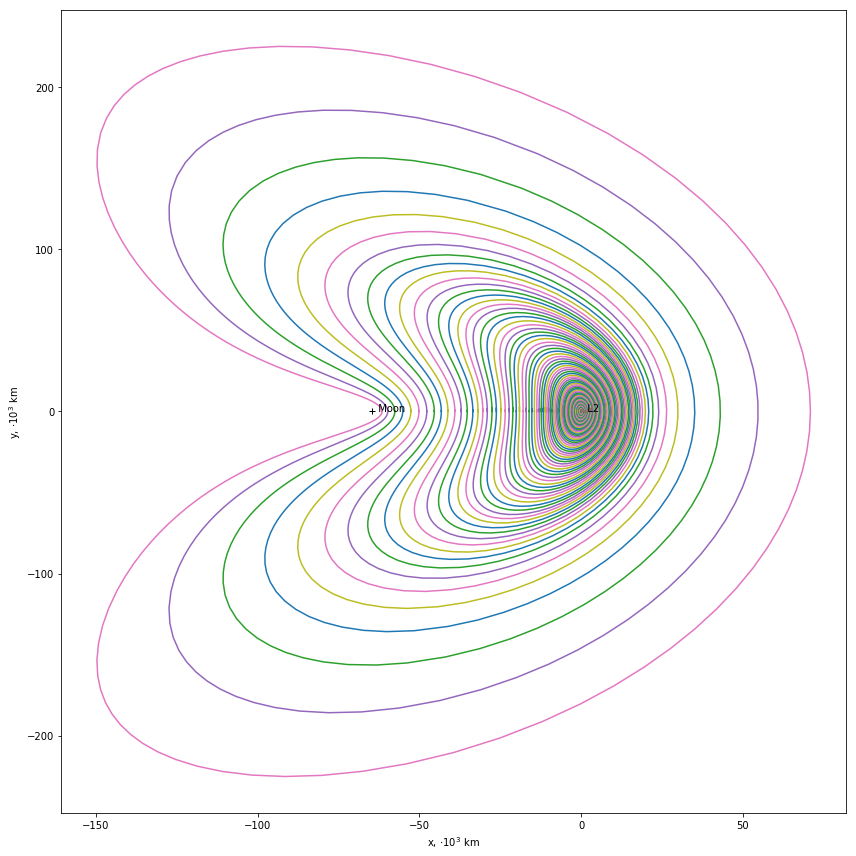

In [15]:
# calculate and plot every 10's orbits for one revolution
evy0   = op.eventY(count=2)
detector = op.event_detector(pmodel, [evy0])

# create figure and plot L1 point
ax = plotter.plot_proj(plottables=[plotter.__getattribute__(point_name), plotter.m], fsize=(12,12),
                       projections=('x-y',),centers={'x':Lpoint},
                       colors='k', ls='', marker='+')
vals = [model.jacobi(states[i]) for i in [-1, 0]]
norm = plt.Normalize(min(vals),max(vals))
for i, s in enumerate(states[::10]):
    dfs, _ = detector.prop(s[:6], 0., 4*np.pi)
    plotter.plot_proj(dfs, ax=ax, projections=('x-y',),centers={'x':Lpoint}, 
                      colors=[plt.cm.coolwarm(norm(model.jacobi(states[i])))])
    print(i, end=' ')

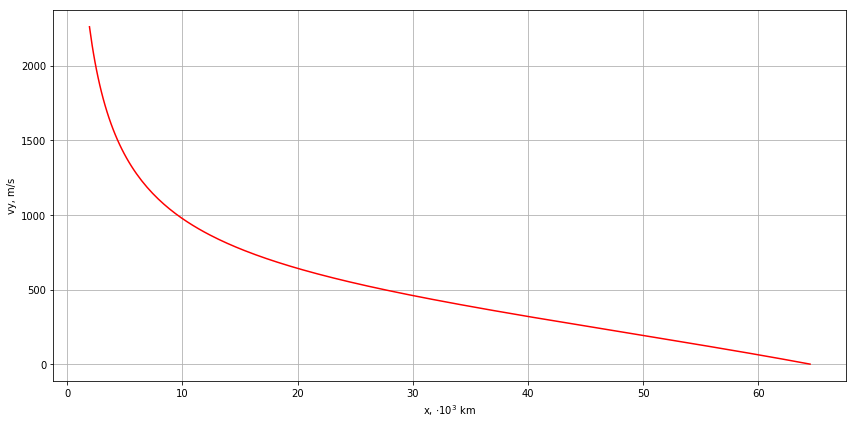

In [16]:
# plot vy(x) graph
arr = np.array(states)
df = pd.DataFrame({'x':arr[:,0], 'vy':arr[:,4]})

plotter.plot_proj(df, fsize=(12, 6), 
                  projections=('x-vy',), 
                  centers={'x':stmmodel.mu1}, 
                  colors='r', grid=True)

In [17]:
# generate file name
fname = 'HLY_' + point_name + '_' + model.const_set + '.csv'
fname

'HLY_L2_Earth-Moon (default).csv'

In [18]:
header = '''Content: Horizontal Lyapunov orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Horizontal Lyapunov Orbits.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: %s
Lagrange point: %s
Columns: %s'''%(model.const_set, point_name, list(dfs.columns[1:]))
print(header)

Content: Horizontal Lyapunov orbits family
Author: Bober S.A.
Generated by: OrbiPy Tutorial - Horizontal Lyapunov Orbits.ipynb
URL: https://bitbucket.org/stas_bober/orbipy/src/master/tutorials/
Constant set: Earth-Moon (default)
Lagrange point: L2
Columns: ['x', 'y', 'z', 'vx', 'vy', 'vz']


In [19]:
# save results to csv
np.savetxt(fname, arr, header=header)